In [63]:
import glob

import numpy as np
import PIL
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import zscore

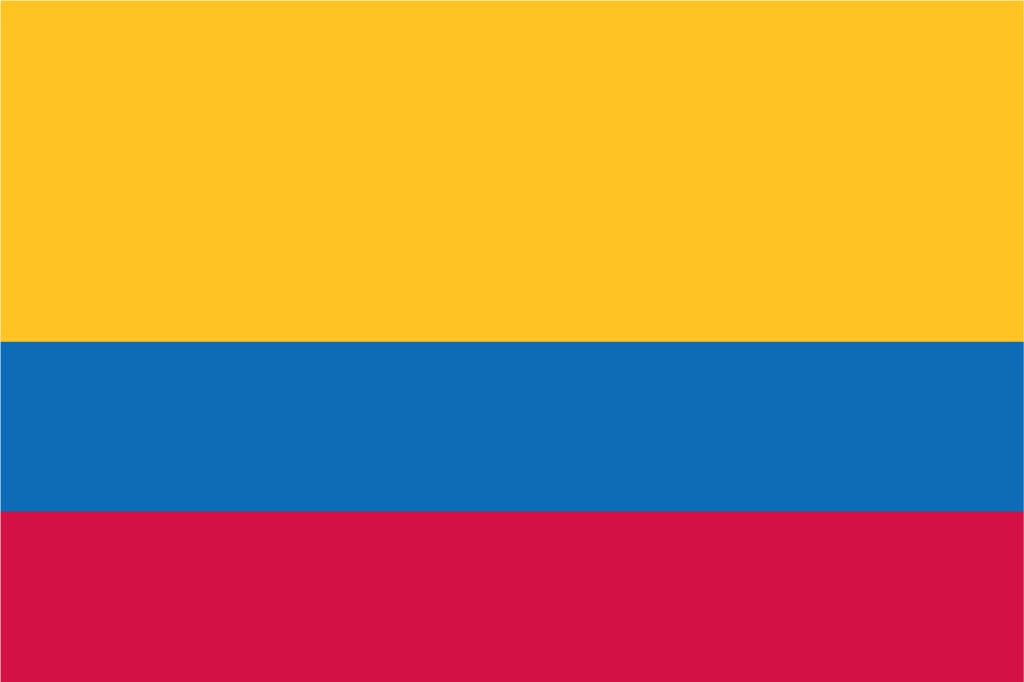

In [90]:
# testing

## to display an image from disk
from IPython.display import Image 

Image('flags/colombia.jpg')

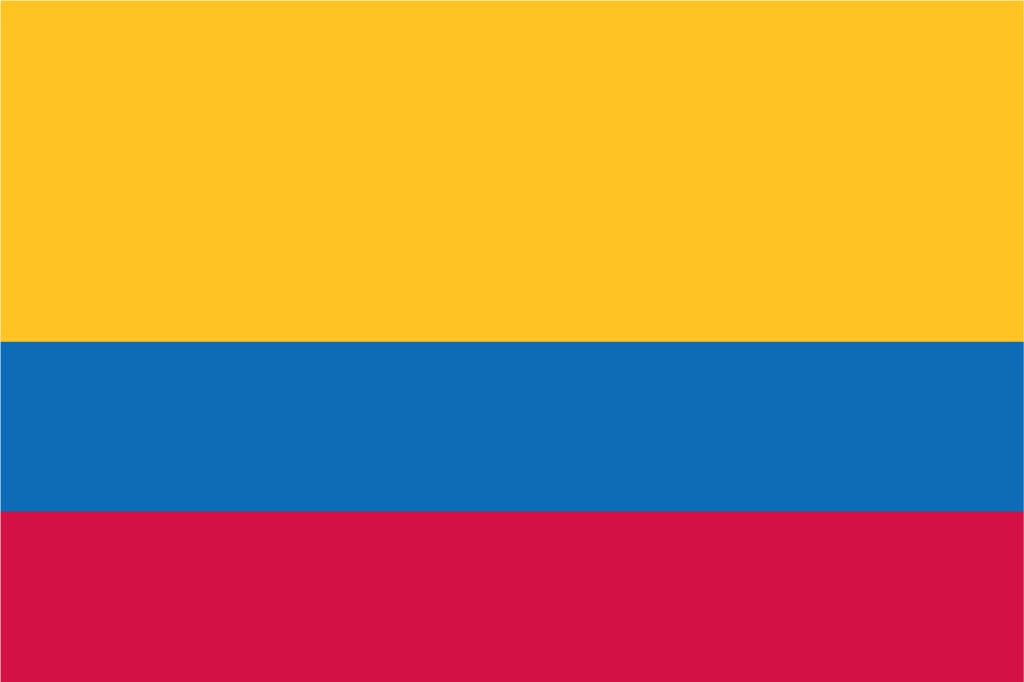

In [91]:
## to display an array as an image
colombia_bitmap = imread('flags/colombia.jpg')
PIL.Image.fromarray(colombia_bitmap)

# Import flag bitmaps as numpy arrays

In [51]:
flag_bitmaps = []

for flag in glob.glob('flags/*.jpg'):
    flag_bitmaps.append( imread(flag) )

# Normalize data

## Resize all flags to the proportions of the largest bounding box

In [127]:
flag_bitmap_shapes = [bitmap.shape for bitmap in flag_bitmaps]

max_first_dimension = max([shape[0] for shape in flag_bitmap_shapes])
max_second_dimension = max([shape[1] for shape in flag_bitmap_shapes])
max_third_dimension = max([shape[2] for shape in flag_bitmap_shapes])

max_bounding_box = (max_first_dimension, max_second_dimension, max_third_dimension)
print('Max bounding box: ({}, {}, {})'.format(*max_bounding_box))

Max bounding box: (684, 1025, 3)


In [133]:
reduced_max_bounding_box = (max_bounding_box[0] // 3, max_bounding_box[1] // 3, max_bounding_box[2])
print('Reduced size bounding box ({}, {}, {})'.format(*reduced_max_bounding_box))

Reduced size bounding box (228, 341, 3)


In [134]:
resized_flag_bitmaps = [imresize(bitmap, size=reduced_max_bounding_box) for bitmap in flag_bitmaps]

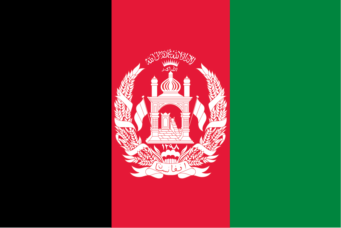

In [135]:
# PIL.Image.fromarray(resized_flag_bitmaps[0])

## Flatten images, then create an input matrix

In [136]:
input_matrix = np.array([bitmap.flatten() for bitmap in resized_flag_bitmaps])

In [137]:
input_matrix.shape

(138, 233244)

## Subtract mean, divide by standard deviation along each pixel dimension

In [139]:
scaled_input_matrix = zscore(input_matrix, axis=0)